## Importing the input vectors

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run the data preparation notebook
X_analog_feb = pd.DataFrame(np.load("npy_files/X_analog_feb.npy"))
X_analog_april_july = pd.DataFrame(np.load("npy_files/X_analog_april_july.npy"))

In [2]:
X_analog_april_july.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,8.368,9.692,9.780,9.364,8.960,8.588,8.244,5.5425,6.1375,3.6950,3.7175,0.0425,0.0425,0.0425,179.0,1259.0,0.0
1,8.620,9.670,9.774,9.354,8.964,8.592,8.244,5.9800,6.1725,3.7725,3.7600,0.0450,0.0425,0.0425,118.0,1250.0,0.0
2,8.686,9.584,9.798,9.382,8.992,8.604,8.254,6.0575,5.4800,3.8950,3.9375,0.0450,0.0450,0.0425,158.0,1259.0,0.0
3,8.486,9.736,9.762,9.344,8.956,8.582,8.234,5.8975,6.2125,3.8325,3.8575,0.0425,0.0425,0.0425,129.0,1249.0,0.0
4,8.808,9.922,9.804,9.388,8.982,8.596,8.248,5.9550,6.1975,3.7750,3.7825,0.0450,0.0425,0.0425,159.0,1269.0,0.0


#### Divide into train data and test data

In [3]:
# The last element contains the labels
labels = X_analog_april_july.iloc[:, -1].values
# The other data points are the data
data = X_analog_april_july.iloc[:, :-1].values

normal_train_data = np.empty((0, 16))  # Empty array with correct shape
anomalous_train_data = np.empty((0, 16))
normal_val_data = np.empty((0, 16))
anomalous_val_data = np.empty((0, 16))
normal_test_data = np.empty((0, 16))
anomalous_test_data = np.empty((0, 16))


# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
split_index = 1262 #June 1st index
split_index2 = 2865 #July 1st index

# Split the data and labels
train_data = data[:split_index]
val_data = data[split_index:split_index2]
test_data = data[split_index2:]

train_labels = labels[:split_index]
val_labels = labels[split_index:split_index2]
test_labels = labels[split_index2:]

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Pass to float
train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_data = train_data.numpy()
val_data = val_data.numpy()
test_data = test_data.numpy()

#Separate into normal and anomalous data
for i in range(len(train_labels)):
     if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :]), axis=0)
     else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :]), axis=0)

for i in range(len(val_labels)):
       if val_labels[i] == 0:
         normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :]), axis=0)
       else:
         anomalous_val_data = np.concatenate((anomalous_val_data, val_data[i:i+1, :]), axis=0)

for i in range(len(test_labels)):
     if test_labels[i] == 0:
        normal_test_data = np.concatenate((normal_test_data, test_data[i:i+1, :]), axis=0)
     else:
        anomalous_test_data = np.concatenate((anomalous_test_data, test_data[i:i+1, :]), axis=0)


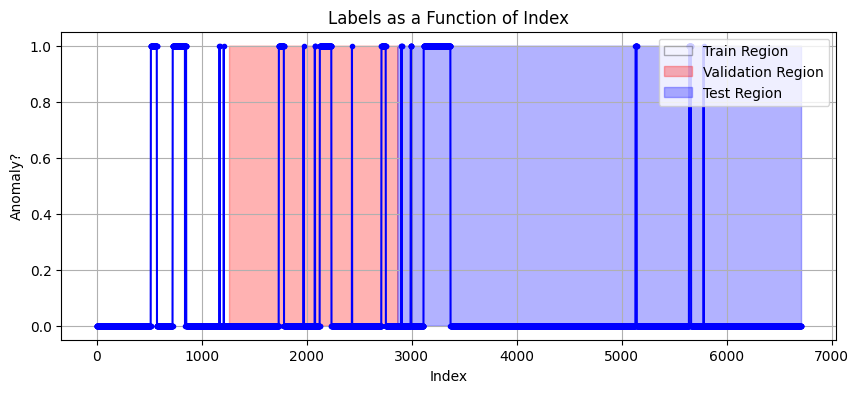

Percentage of anomalies in the entire data set: 10.34%

Train Labels (1262 samples) -     Normal: 85.02%, Anomalous: 14.98%
Validation Labels (1603 samples) - Normal: 87.09%, Anomalous: 12.91%
Test Labels (3846 samples) -       Normal: 92.25%, Anomalous: 7.75%


In [4]:
from matplotlib.patches import Patch
labels_int = [int(label) for label in labels]

# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, 'b.-', label='Labels')
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index) & (np.arange(len(labels)) < split_index2), color='red', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index2), color='blue', alpha=0.3)
legend_elements = [Patch(facecolor='white', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels as a Function of Index')
plt.grid(True)
plt.show()


print(f"Percentage of anomalies in the entire data set: {(100*sum(labels)/len(labels)):.2f}%\n")


from collections import Counter
def calculate_proportions(labels):
    counter = Counter(labels)
    total = len(labels)
    true_proportion = counter[True] / total
    false_proportion = counter[False] / total
    return true_proportion, false_proportion

# Calculate proportions for each list
train_true_prop, train_false_prop = calculate_proportions(train_labels)
val_true_prop, val_false_prop = calculate_proportions(val_labels)
test_true_prop, test_false_prop = calculate_proportions(test_labels)
# Print the proportions
print(f"Train Labels ({len(train_labels)} samples) -     Normal: {train_false_prop*100:.2f}%, Anomalous: {train_true_prop*100:.2f}%")
print(f"Validation Labels ({len(val_labels)} samples) - Normal: {val_false_prop*100:.2f}%, Anomalous: {val_true_prop*100:.2f}%")
print(f"Test Labels ({len(test_labels)} samples) -       Normal: {test_false_prop*100:.2f}%, Anomalous: {test_true_prop*100:.2f}%")

In [5]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)  # Fit and transform

val_data = scaler.transform(val_data)  # Transform (using the scaler fitted on train data)

# Reshape the normal training data to 2D, fit the scaler, and transform it
normal_train_data = scaler.fit_transform(normal_train_data)  # Fit and transform

test_data = scaler.transform(test_data)  # Transform (using the scaler fitted on train data)

# Reshape and transform the rest of the datasets using the same scaler
# Normal validation data
normal_val_data = scaler.transform(normal_val_data)

# Normal test data
normal_test_data = scaler.transform(normal_test_data)

# Anomalous training data
anomalous_train_data = scaler.transform(anomalous_train_data)

# Anomalous validation data
anomalous_val_data = scaler.transform(anomalous_val_data)

# Anomalous test data
anomalous_test_data = scaler.transform(anomalous_test_data)

In [6]:
normal_train_data

array([[0.77406202, 0.91233973, 0.89602613, ..., 0.00328272, 0.00212439,
        0.00668718],
       [0.80831975, 0.90897988, 0.89439315, ..., 0.00328272, 0.00130937,
        0.00663618],
       [0.81729202, 0.89584603, 0.90092559, ..., 0.00328272, 0.00184381,
        0.00668718],
       ...,
       [0.80560095, 0.9105071 , 0.90636911, ..., 0.00328272, 0.00132273,
        0.00736723],
       [0.80016322, 0.90836905, 0.90582479, ..., 0.00328272, 0.00130937,
        0.00741824],
       [0.83849922, 0.9202811 , 0.9118129 , ..., 0.00328272, 0.00158995,
        0.00702154]])

## Autoencoder

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 156.6674 - val_loss: 94.1561
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 67.9159 - val_loss: 68.5067
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.0470 - val_loss: 52.2704
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.0512 - val_loss: 44.8573
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1975 - val_loss: 43.3479
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7297 - val_loss: 37.1781
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.8068 - val_loss: 38.5736
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.1182 - val_loss: 36.4063
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.1312 - val_loss: 36.5508
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4034 - val_loss: 34.5723
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5304 - val_loss: 34.6451
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━

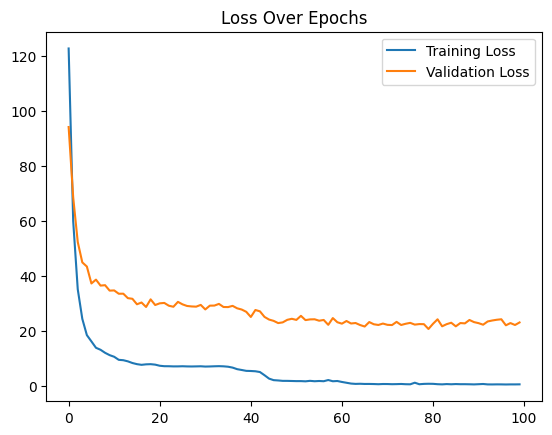

In [7]:
# Define input dimension
input_dim = data.shape[1]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(128, activation='relu', name='encoder_layer1')(input_layer)
encoded = Dense(64, activation='relu', name='encoder_layer2')(encoded)
encoded = Dense(32, activation='relu', name='encoder_layer3')(encoded)
bottleneck = Dense(12, activation='relu', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(32, activation='relu', name='decoder_layer1')(bottleneck)
decoded = Dense(64, activation='relu', name='decoder_layer2')(decoded)
decoded = Dense(128, activation='relu', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss

# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),#learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data,  # Input and target are the same for autoencoders
    y=normal_train_data,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30, 
    validation_data=(normal_val_data, normal_val_data)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


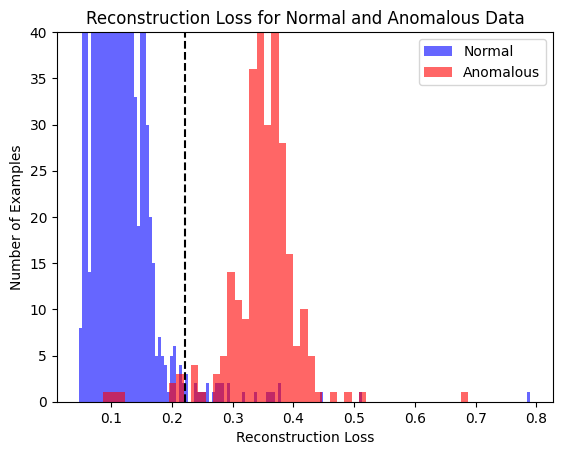

Accuracy = 99.08996359854395%
Precision = 91.48264984227129%
Recall = 97.31543624161074%
F1 Score = 94.3089430894309%


In [62]:
# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_normal = autoencoder.predict(normal_val_data)
val_loss = tf.keras.losses.mae(reconstructions_normal, normal_val_data)

# Compute the first quartile (Q1) and third quartile (Q3)
Q1 = np.percentile(val_loss, 25)
Q3 = np.percentile(val_loss, 75)
IQR = Q3 - Q1
# Define the threshold using Tukey's fence - 1.5 for outliers. 3 for far-out results
k = 3
threshold = Q3 + k * IQR


reconstructions_test_normal = autoencoder.predict(normal_test_data)
normal_test_loss = tf.keras.losses.mae(reconstructions_test_normal, normal_test_data)

reconstructions_test_anomalous = autoencoder.predict(anomalous_test_data)
anomalous_test_loss = tf.keras.losses.mae(reconstructions_test_anomalous, anomalous_test_data)

# Plot both losses on the same histogram
plt.hist(normal_test_loss, bins=150, alpha=0.6, color='blue', label='Normal')
plt.hist(anomalous_test_loss, bins=50, alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous Data")
plt.axvline(x=threshold, color='black', linestyle='--')
plt.ylim((0, 40))
plt.show()


# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label = 0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label = 0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label = 0)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

In [63]:
# Generate the confusion matrix
cm = confusion_matrix(~test_labels, preds)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 290    8]
 [  27 3521]]


#### Low pass filter

In [64]:
# Reshape test_loss to 2D array for MinMaxScaler
test_loss_reshaped = test_loss.numpy().reshape(-1, 1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the test_loss
test_loss_normalized = scaler.fit_transform(test_loss_reshaped)

# Flatten the normalized test_loss back to 1D array
test_loss_normalized = test_loss_normalized.flatten()

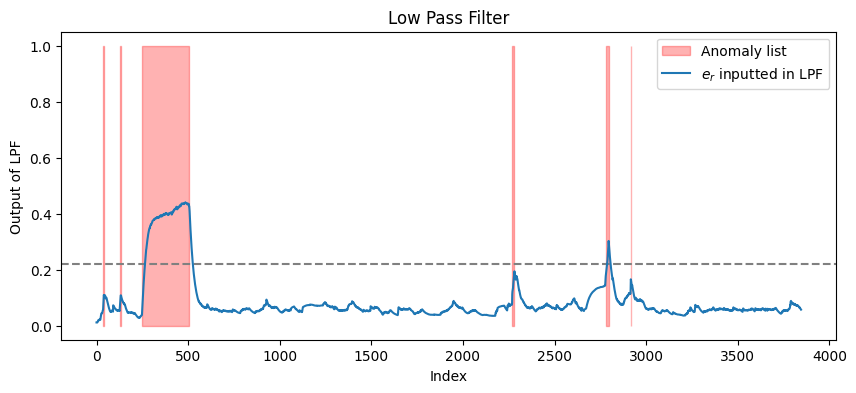

In [76]:
def low_pass_filter(data, alpha):
    y = np.zeros_like(data)
    y[0] = data[0]
    for i in range(1, len(data)):
        y[i] = y[i-1] + alpha * (data[i] - y[i-1])
    return y

# Example usage
alpha = 0.04  # You can adjust this hyperparameter
lpf_output = low_pass_filter(test_loss_normalized, alpha)

# Plot the original and filtered data
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(labels_int[split_index2:])), 0, 1, where=np.array(labels_int[split_index2:]) == 1, color='red', alpha=0.3, label='Anomaly list')
plt.axhline(y=threshold, color='gray', linestyle='--')
plt.plot(lpf_output, label="$e_r$ inputted in LPF", linestyle='-')
plt.legend()
plt.title('Low Pass Filter')
plt.xlabel('Index')
plt.ylabel('Output of LPF')
plt.show()